In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf

In [10]:
# Load & Preprocess the data
df = pd.read_csv('age_gender.csv')
df = df.dropna()
df = df.drop ('img_name', axis = 1)
df.head()

,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...


In [11]:
# Transform pixel to (48, 48, 1)
X = df['pixels'].apply(lambda x: np.array(list(map(int, x.split(' ')))))
X = np.stack(X, axis=0)
X = X.reshape(-1, 48, 48, 1)
X = X / 255.0

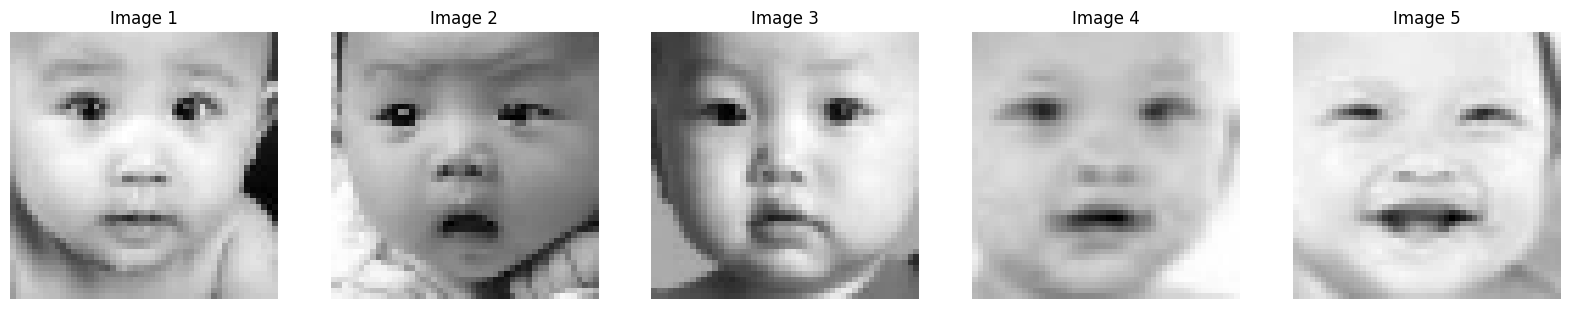

In [12]:
# Image Visualization Check
fig,axes = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axes[i].imshow(X[i, :, :, 0], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')
plt.show()

In [13]:
# Normalize age to 0 - 1
# Gender to 2 classes
# Ethnicity to 5 classes

y_age = df['age'].astype('float32')
y_gender = to_categorical(df['gender'], num_classes = 2)
y_ethnicity = to_categorical(df['ethnicity'], num_classes = 5)

In [14]:
# Train & Test sets
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test, y_eth_train, y_eth_test = train_test_split(
    X, y_age, y_gender, y_ethnicity,
    test_size=0.2,
    random_state=42
)

In [15]:
#CNN
def ConvFunc(x, filters=32, kernel_size=(3, 3), dropout_rate=0.1):
    x = Conv2D(
        filters,
        kernel_size=kernel_size,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=l2(0.001)
    )(x)

    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Dropout(dropout_rate)(x)
    return x

In [16]:
from tensorflow.keras.layers import Activation
def swish(x):
    return x * tf.nn.sigmoid(x)

In [35]:
#Multi-feature Model
def build_multi_feature_model():
    inputs = Input(shape=(48, 48, 1))

    #Convolutional Layers
    x = ConvFunc(inputs, 32, dropout_rate=0.1)
    x = ConvFunc(x, 64, dropout_rate=0.15)
    x = ConvFunc(x, 128, dropout_rate=0.2)
    x = ConvFunc(x, 256, dropout_rate=0.25)
    x = Flatten()(x)

    #Age
    age_branch = Dense(256)(x)
    age_branch = Activation(swish)(age_branch)
    age_branch = Dropout(0.4)(age_branch)
    age_output = Dense(1, activation="softplus", name = 'age_output')(age_branch)

    #Gender
    gender_branch = Dense(256, activation="relu")(x)
    gender_branch = Dropout(0.4)(gender_branch)
    gender_output = Dense(2, activation="softmax", name = 'gender_output')(gender_branch)

    #Ethnicity
    ethnicity_branch = Dense(256, activation="relu")(x)
    ethnicity_branch = Dropout(0.4)(ethnicity_branch)
    ethnicity_output = Dense(5, activation="softmax", name = 'ethnicity_output')(ethnicity_branch)

    model = Model(inputs, [age_output, gender_output, ethnicity_output])
    return model

multi_feature_model = build_multi_feature_model()

In [36]:
# Compile Model
multi_feature_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss={
        'age_output': tf.keras.losses.Huber(delta=2.0),
        'gender_output': tf.keras.losses.BinaryCrossentropy(),
        'ethnicity_output': tf.keras.losses.CategoricalCrossentropy()
    },
    loss_weights={
        'age_output': 1.5,
        'gender_output': 1,
        'ethnicity_output': 2
    },
    metrics={
        'age_output': 'mae',
        'gender_output': 'accuracy',
        'ethnicity_output': 'accuracy'
    }
)
multi_feature_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 48, 48,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 24, 24,    │          0 │ activation_10[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 24, 24,    │          0 │ max_pooling2d_8[… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 24, 24,    │     18,496 │ dropout_14[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 12, 12,    │          0 │ activation_11[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 12, 12,    │          0 │ max_pooling2d_9[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 12, 12,    │     73,856 │ dropout_15[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        512 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 6, 6, 128) │          0 │ activation_12[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 6, 6, 128) │          0 │ max_pooling2d_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 6, 6, 256) │    295,168 │ dropout_16[0][0]

 Total params: 2,162,056 (8.25 MB)

 Trainable params: 2,161,096 (8.24 MB)

 Non-trainable params: 960 (3.75 KB)

In [37]:
#Training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=5, verbose=1, factor=0.5, min_lr=1e-5
)

multi_feature_model.fit(
    X_train,
    {
        'age_output': y_age_train,
        'gender_output': y_gender_train,
        'ethnicity_output': y_eth_train
    },
    validation_data=(
        X_test,
        {
            'age_output': y_age_test,
            'gender_output': y_gender_test,
            'ethnicity_output': y_eth_test
        }
    ),
    batch_size=128,
    epochs=100,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - age_output_loss: 31.9209 - age_output_mae: 16.9254 - ethnicity_output_accuracy: 0.3821 - ethnicity_output_loss: 1.8962 - gender_output_accuracy: 0.6150 - gender_output_loss: 0.7375 - loss: 53.3703 - val_age_output_loss: 33.1294 - val_age_output_mae: 17.4663 - val_ethnicity_output_accuracy: 0.4330 - val_ethnicity_output_loss: 1.4041 - val_gender_output_accuracy: 0.6575 - val_gender_output_loss: 0.6444 - val_loss: 53.8787 - learning_rate: 2.0000e-04
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - age_output_loss: 22.7361 - age_output_mae: 12.3264 - ethnicity_output_accuracy: 0.4790 - ethnicity_output_loss: 1.3320 - gender_output_accuracy: 0.7072 - gender_output_loss: 0.5775 - loss: 38.3025 - val_age_output_loss: 23.0889 - val_age_output_mae: 12.5083 - val_ethnicity_output_accuracy: 0.4813 - val_ethnicity_output_loss: 1.2284 - val_gender_output_accuracy: 0.7277 - val_gender_output_loss: 0.5621 - val_loss: 38.6741 - learning_

In [38]:
#Evaluation
evaluation = multi_feature_model.evaluate(X_test, {
    'age_output': y_age_test,
    'gender_output': y_gender_test,
    'ethnicity_output': y_eth_test
})
print('Test Results:', evaluation)

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - age_output_loss: 11.9430 - age_output_mae: 6.8995 - ethnicity_output_accuracy: 0.7317 - ethnicity_output_loss: 0.7333 - gender_output_accuracy: 0.8679 - gender_output_loss: 0.2885 - loss: 20.5943
Test Results: [20.63271713256836, 11.988649368286133, 0.2986992299556732, 0.719329297542572, 6.9124436378479, 0.7352879047393799, 0.8622653484344482]


In [39]:
#Evaluation Table
metric_names = [
    'Total Loss (weighted)',
    'Age Loss (Huber)',
    'Gender Loss (Crossentropy)',
    'Ethnicity Loss (Crossentropy)',
    'Age MAE (years)',
    'Ethnicity Accuracy',
    'Gender Accuracy'
]

print("\n📊 Model Evaluation Results:")
print("-" * 50)
for name, value in zip(metric_names, evaluation):
    if "Accuracy" in name:
        print(f"{name:<35}: {value:.2%}")
    elif "MAE" in name:
        print(f"{name:<35}: {value:.4f}")

    else:
        print(f"{name:<35}: {value:.4f}")
print("-" * 50)


📊 Model Evaluation Results:
--------------------------------------------------
Total Loss (weighted)              : 20.6327
Age Loss (Huber)                   : 11.9886
Gender Loss (Crossentropy)         : 0.2987
Ethnicity Loss (Crossentropy)      : 0.7193
Age MAE (years)                    : 6.9124
Ethnicity Accuracy                 : 73.53%
Gender Accuracy                    : 86.23%
--------------------------------------------------


In [40]:
!pip install streamlit opencv-python-headless pyngrok tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.9 MB/s eta 0:00:00


In [32]:
multi_feature_model.save("multi_feature_model.h5")

In [20]:
from google.colab import files
files.download('multi_feature_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>